In [1]:
import numpy as np
import scampi_ks_solver
import matplotlib.pyplot as plt
from scipy.io import matlab
# Installl the following package from the UTIAS repository: https://github.com/utiasSTARS/liegroups
from liegroups.numpy import SO3


# IK/FK Consistency Experiments
This is the same expriment carried out in matlab. The first solver is used as ground-truth for the second solver. The center points are imported from matlab and then used to run the IK solver. Then, the IK solver computes the cable lengths, forces, and optimized end-effector orientation. 

In the next step, the optimized orientation and the intilal center point values are purturbed (as carried out in Matlab) and fed to the scond solver alongside the cable lenth and foces for the first solver. The second solver computes the optimized pose of the robot. Finally, the errors are plotted similar to the procedure in the Matlab code.

In [2]:
centers = matlab.loadmat('matlab_data/simulation/centers.mat')['centers'].astype(np.float64)

In [3]:
robot_params = scampi_ks_solver.CableRobotParams(0.1447, 353.16)

b1 = np.array([-0.1, 0.1, 0])
b2 = np.array([0.1, 0.1, 0])
b3 = np.array([0.1, -0.1, 0])
b4 = np.array([-0.1, -0.1, 0])

a1 = np.array([0, 100, 50])
a2 = np.array([200, 100, 50])
a3 = np.array([200, 0, 50])
a4 = np.array([0, 0, 50])

robot_params.setEEAnchors(b1,b2,b3,b4)
robot_params.setPulleyPoses(a1,a2,a3,a4)
robot_params.setCog(np.array([0., 0., 0.]))

In [4]:
R_init = np.eye(3)
tr_errors = []
orient_errors = []
for center in centers.tolist():
    R, lc_cat, cable_forces, C1, C2, b_in_w \
    = scampi_ks_solver.inverseKinematicsSolver(robot_params, np.array(center), R_init)
#     print(lc_cat)
    R_rand = SO3.exp(np.random.randn(3)*0.5*np.pi/180).as_matrix()
    R_fk_init = R @ R_rand
    
    r_rand = np.random.randn(3)*0.1
    center_fk_inti = np.array(center) + r_rand
    
    fk_R, fk_r, fk_fc, fk_C1, fk_C2, fk_b_in_w\
    = scampi_ks_solver.forwardKinematicsSolver(robot_params, lc_cat, cable_forces[:,0], center_fk_inti, R_fk_init)
    
    e_r = (fk_r.squeeze() - center).reshape(3,1)
    translation_error = e_r.T@e_r
    orientation_error = np.linalg.norm(SO3(fk_R.T@R).log())*180/np.pi    
    tr_errors.append(translation_error)
    orient_errors.append(orientation_error)

tr_errors = np.vstack(tr_errors)
orient_errors = np.vstack(orient_errors)

The error value for the last (closest) pont in each travel towards the pulleys were much higher. For visualization purposes, I plot two versions, one excluding that point and another with that last point.
## All But the Last

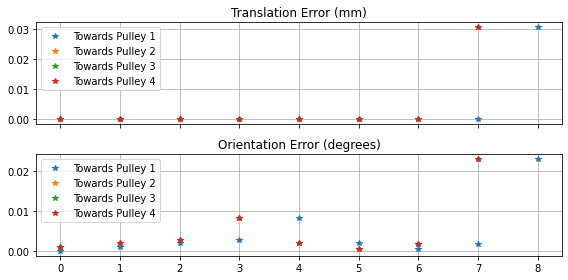

In [5]:
fig = plt.figure(figsize=(8,4))
ax = fig.subplots(2,1, sharex = True)
ax[0].plot(tr_errors[0:9]*1000,'*')
ax[0].plot(tr_errors[11:19]*1000,'*')
ax[0].plot(tr_errors[21:29]*1000,'*')
ax[0].plot(tr_errors[31:39]*1000,'*')
ax[0].grid(True)
ax[0].set_title('Translation Error (mm)')
ax[0].legend(['Towards Pulley 1', 'Towards Pulley 2', 'Towards Pulley 3', 'Towards Pulley 4'])


ax[1].plot(orient_errors[0:9],'*')
ax[1].plot(orient_errors[11:19],'*')
ax[1].plot(orient_errors[21:29],'*')
ax[1].plot(orient_errors[31:39],'*')
ax[1].grid(True)
ax[1].set_title('Orientation Error (degrees)')
ax[1].legend(['Towards Pulley 1', 'Towards Pulley 2', 'Towards Pulley 3', 'Towards Pulley 4'])

plt.tight_layout()

# plt.savefig('autodiff_errors_all_but_last.pdf')


## All

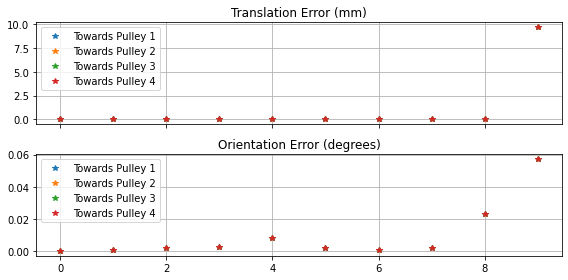

In [6]:
fig = plt.figure(figsize=(8,4))
ax = fig.subplots(2,1, sharex = True)
ax[0].plot(tr_errors[0:10]*1000,'*')
ax[0].plot(tr_errors[10:20]*1000,'*')
ax[0].plot(tr_errors[20:30]*1000,'*')
ax[0].plot(tr_errors[30:40]*1000,'*')
ax[0].grid(True)
ax[0].set_title('Translation Error (mm)')
ax[0].legend(['Towards Pulley 1', 'Towards Pulley 2', 'Towards Pulley 3', 'Towards Pulley 4'])


ax[1].plot(orient_errors[0:10],'*')
ax[1].plot(orient_errors[10:20],'*')
ax[1].plot(orient_errors[20:30],'*')
ax[1].plot(orient_errors[30:40],'*')
ax[1].grid(True)
ax[1].set_title('Orientation Error (degrees)')
ax[1].legend(['Towards Pulley 1', 'Towards Pulley 2', 'Towards Pulley 3', 'Towards Pulley 4'])

plt.tight_layout()

plt.savefig('autodiff_errors_all.pdf')


# Performance Statistics
In this section, we run the solver for various perturbed values of the center points and capture the execution time. Finally, we plot a histogram of the performance.

In [13]:
import time
time_stats_ik = []
time_stats_fk = []

for i in range(100):
    R_init = np.eye(3)
    tr_errors = []
    orient_errors = []
    center_pert = centers + np.random.randn(centers.shape[0],3)*0.5
    for center in centers.tolist():
        start_stamp = time.time()
        R, lc_cat, cable_forces, C1, C2, b_in_w \
        = scampi_ks_solver.inverseKinematicsSolver(np.array(center), R_init)
        end_stamp = time.time()
        time_stats_ik.append((end_stamp-start_stamp)*1000.)
    #     print(lc_cat)
        R_rand = SO3.exp(np.random.randn(3)*0.5*np.pi/180).as_matrix()
        R_fk_init = R @ R_rand

        r_rand = np.random.randn(3)*0.1
        center_fk_inti = np.array(center) + r_rand

        start_stamp = time.time()
        fk_R, fk_r, fk_fc, fk_C1, fk_C2, fk_b_in_w\
        = scampi_ks_solver.forwardKinematicsSolver(lc_cat, cable_forces[:,0], center_fk_inti, R_fk_init)
        end_stamp = time.time()
        time_stats_fk.append((end_stamp-start_stamp)*1000.)

        e_r = (fk_r.squeeze() - center).reshape(3,1)
        translation_error = e_r.T@e_r
        orientation_error = np.linalg.norm(SO3(fk_R.T@R).log())*180/np.pi    
        tr_errors.append(translation_error)
        orient_errors.append(orientation_error)
    end_stamp = time.time()

    tr_errors = np.vstack(tr_errors)
    orient_errors = np.vstack(orient_errors)

ination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.175424e+07, Final cost: 9.606247e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 2.483298e+02, Final cost: 6.387037e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 47, Initial cost: 1.582927e+07, Final cost: 2.610777e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 9.357070e+02, Final cost: 3.464783e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 42, Initial cost: 7.087117e+06, Final cost: 9.164717e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 3.222357e+03, Final cost: 6.336911e-15, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 16, Initial cost: 4.451660e+04, Final cost: 1.710757e-15, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cos

Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 1.114630e+01, Final cost: 6.743021e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.866488e+06, Final cost: 1.008948e+02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 14, Initial cost: 3.155840e+04, Final cost: 1.869383e-15, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.034029e+08, Final cost: 5.237563e-03, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 1.430685e+02, Final cost: 1.507436e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.141480e+08, Final cost: 1.344307e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 8.113217e+00, Final cost: 1.172627e-21, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.821591e+08

Ceres Solver Report: Iterations: 51, Initial cost: 3.141480e+08, Final cost: 1.344307e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 14, Initial cost: 3.638626e+02, Final cost: 1.491732e-20, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.821591e+08, Final cost: 2.059459e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 14, Initial cost: 1.887166e+02, Final cost: 1.719213e-21, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.049980e+08, Final cost: 2.248698e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 7.346715e+01, Final cost: 3.085491e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.908742e+07, Final cost: 4.332017e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 2.960135e+01, Final cost: 7.489978e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.175424e

Ceres Solver Report: Iterations: 12, Initial cost: 2.150970e+02, Final cost: 2.198748e-20, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.908742e+07, Final cost: 4.332017e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 3.230737e+02, Final cost: 4.959129e-21, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.175424e+07, Final cost: 9.606247e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 8.447095e+00, Final cost: 4.898450e-21, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 47, Initial cost: 1.582927e+07, Final cost: 2.610777e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 5.882308e+02, Final cost: 4.403862e-21, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 42, Initial cost: 7.087117e+06, Final cost: 9.164717e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 3.402549e+03, F

Ceres Solver Report: Iterations: 12, Initial cost: 4.874443e+01, Final cost: 7.760069e-21, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.175424e+07, Final cost: 9.606247e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 2.822896e+02, Final cost: 1.779379e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 47, Initial cost: 1.582927e+07, Final cost: 2.610777e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 14, Initial cost: 3.199866e+03, Final cost: 8.041665e-21, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 42, Initial cost: 7.087117e+06, Final cost: 9.164717e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 13, Initial cost: 7.274030e+03, Final cost: 4.767007e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 8.483545e+03, Fina

Ceres Solver Report: Iterations: 15, Initial cost: 2.031396e+02, Final cost: 5.032477e-20, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.049980e+08, Final cost: 2.248698e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 1.118060e+01, Final cost: 3.290367e-17, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.908742e+07, Final cost: 4.332017e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 6.210914e+02, Final cost: 4.397283e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.175424e+07, Final cost: 9.606247e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 3.473439e+02, Final cost: 7.188848e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 47, Initial cost: 1.582927e+07, Final cost: 2.610777e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 1.780079e+03

Ceres Solver Report: Iterations: 12, Initial cost: 5.945811e+01, Final cost: 1.120953e-21, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.141480e+08, Final cost: 1.344307e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 1.569067e+01, Final cost: 4.059964e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.821591e+08, Final cost: 2.059459e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 14, Initial cost: 2.377884e+01, Final cost: 2.206512e-17, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.049980e+08, Final cost: 2.248698e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 3.181850e+02, Final cost: 3.163946e-21, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.908742e+07, Final cost: 4.332017e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 14, Initial cost: 5.282681e

Ceres Solver Report: Iterations: 42, Initial cost: 7.087117e+06, Final cost: 9.164717e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 3.190913e+03, Final cost: 9.178205e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 9, Initial cost: 4.350584e+02, Final cost: 5.832403e-15, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.866488e+06, Final cost: 1.008948e+02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 1.011005e+05, Final cost: 9.822668e-15, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.034029e+08, Final cost: 5.237563e-03, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 1.299501e+02, Final cost: 3.651847e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.141480e+08, Fi

Ceres Solver Report: Iterations: 13, Initial cost: 3.492735e+02, Final cost: 2.779279e-22, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.049980e+08, Final cost: 2.248698e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 1.209035e+02, Final cost: 5.533736e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.908742e+07, Final cost: 4.332017e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 3.844494e+01, Final cost: 2.311770e-17, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.175424e+07, Final cost: 9.606247e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 9.360425e+01, Final cost: 1.735223e-17, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 47, Initial cost: 1.582927e+07, Final cost: 2.610777e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 14, Initial cost: 4.450337e+03

Ceres Solver Report: Iterations: 47, Initial cost: 1.582927e+07, Final cost: 2.610777e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 5.703954e+02, Final cost: 6.186137e-17, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 42, Initial cost: 7.087117e+06, Final cost: 9.164717e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 7.266291e+02, Final cost: 3.227497e-17, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 3.837647e+03, Final cost: 2.261537e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.866488e+06, Final cost: 1.008948e+02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 6.971391e+04, Final cost: 9.379109e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.034029e+08, Fina

Ceres Solver Report: Iterations: 9, Initial cost: 3.251896e+03, Final cost: 6.622217e-15, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 9, Initial cost: 1.496983e+03, Final cost: 1.220790e-16, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.866488e+06, Final cost: 1.008948e+02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 1.831641e+04, Final cost: 6.848720e-13, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 45, Initial cost: 1.035065e+09, Final cost: 1.110700e-02, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 1.182093e+00, Final cost: 8.513512e-21, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.141480e+08, Final cost: 1.344307e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 6.422514e+01, Fin

Ceres Solver Report: Iterations: 51, Initial cost: 1.866488e+06, Final cost: 1.008948e+02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 14, Initial cost: 1.071331e+05, Final cost: 7.284954e-15, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 45, Initial cost: 1.035065e+09, Final cost: 1.110700e-02, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 1.431633e+02, Final cost: 2.455832e-20, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.141480e+08, Final cost: 1.344307e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 2.582884e+01, Final cost: 9.716713e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.821591e+08, Final cost: 2.059459e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 1.544179e+01, Final cost: 8.684226e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.049980e+08

Ceres Solver Report: Iterations: 51, Initial cost: 3.175424e+07, Final cost: 9.606247e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 13, Initial cost: 1.220461e+03, Final cost: 4.213208e-17, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 47, Initial cost: 1.582927e+07, Final cost: 2.610777e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 4.582599e+02, Final cost: 1.314734e-20, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 42, Initial cost: 7.087117e+06, Final cost: 9.164717e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 2.711945e+03, Final cost: 8.044309e-17, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 22, Initial cost: 8.849283e+04, Final cost: 3.794525e-17, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.866488e+06, Fina

Ceres Solver Report: Iterations: 51, Initial cost: 3.175424e+07, Final cost: 9.606247e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 2.022165e+02, Final cost: 3.798144e-20, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 47, Initial cost: 1.582927e+07, Final cost: 2.610777e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 1.166180e+03, Final cost: 6.929058e-17, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 42, Initial cost: 7.087117e+06, Final cost: 9.164717e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 3.523859e+02, Final cost: 1.687848e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 5.952860e+02, Final cost: 2.354477e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.866488e+06, Fina

Ceres Solver Report: Iterations: 12, Initial cost: 3.349694e+03, Final cost: 3.854376e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 18, Initial cost: 1.338418e+04, Final cost: 3.620229e-17, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.866488e+06, Final cost: 1.008948e+02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 13, Initial cost: 1.823842e+02, Final cost: 1.855595e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.034029e+08, Final cost: 5.237563e-03, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 1.320747e+02, Final cost: 4.251654e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.141480e+08, Final cost: 1.344307e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 5.123856e+01

Ceres Solver Report: Iterations: 45, Initial cost: 1.035065e+09, Final cost: 1.110700e-02, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 3.169975e+02, Final cost: 9.360350e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.141480e+08, Final cost: 1.344307e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 6.872420e+00, Final cost: 1.649543e-20, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.821591e+08, Final cost: 2.059459e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 8.600390e+01, Final cost: 2.435314e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.049980e+08, Final cost: 2.248698e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 1.169844e+02, Final cost: 3.386142e-20, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.908742e+07

Ceres Solver Report: Iterations: 42, Initial cost: 7.087117e+06, Final cost: 9.164717e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 8.852671e+01, Final cost: 7.183067e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 17, Initial cost: 1.350484e+04, Final cost: 2.390826e-16, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.866488e+06, Final cost: 1.008948e+02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 24, Initial cost: 8.992003e+04, Final cost: 2.372164e-14, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.034029e+08, Final cost: 5.237563e-03, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 4.684287e-01, Final cost: 2.975060e-22, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.141480e+08, F

Ceres Solver Report: Iterations: 51, Initial cost: 3.175424e+07, Final cost: 9.606247e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 9.828475e+01, Final cost: 1.941124e-17, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 47, Initial cost: 1.582927e+07, Final cost: 2.610777e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 1.122405e+02, Final cost: 1.091931e-16, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 42, Initial cost: 7.087117e+06, Final cost: 9.164717e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 2.811581e+02, Final cost: 2.699553e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 22, Initial cost: 2.159922e+04, Final cost: 1.196858e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.866488e+06, Fina

Ceres Solver Report: Iterations: 51, Initial cost: 1.821591e+08, Final cost: 2.059459e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 14, Initial cost: 3.900422e+01, Final cost: 1.015785e-17, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.049980e+08, Final cost: 2.248698e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 15, Initial cost: 3.674759e+02, Final cost: 1.637233e-20, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.908742e+07, Final cost: 4.332017e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 7.046883e+02, Final cost: 9.083989e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.175424e+07, Final cost: 9.606247e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 7.611441e+01, Final cost: 2.833699e-17, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 47, Initial cost: 1.582927e

Ceres Solver Report: Iterations: 11, Initial cost: 5.563398e+03, Final cost: 1.584071e-16, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 13, Initial cost: 1.140187e+04, Final cost: 2.350162e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.866488e+06, Final cost: 1.008948e+02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 17, Initial cost: 3.966678e+04, Final cost: 1.054064e-13, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.034029e+08, Final cost: 5.237563e-03, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 4.435356e+00, Final cost: 4.826204e-21, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.141480e+08, Final cost: 1.344307e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 5.468123e+02

Ceres Solver Report: Iterations: 13, Initial cost: 6.889820e+01, Final cost: 3.443824e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.175424e+07, Final cost: 9.606247e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 13, Initial cost: 1.205115e+03, Final cost: 9.825689e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 47, Initial cost: 1.582927e+07, Final cost: 2.610777e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 1.494652e+02, Final cost: 3.483040e-17, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 42, Initial cost: 7.087117e+06, Final cost: 9.164717e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 3.556541e+03, Final cost: 3.766062e-17, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 9.123428e+03, Fina

Ceres Solver Report: Iterations: 12, Initial cost: 5.933536e+01, Final cost: 3.508428e-20, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.049980e+08, Final cost: 2.248698e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 1.758956e+00, Final cost: 2.712395e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.908742e+07, Final cost: 4.332017e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 4.701772e+02, Final cost: 6.649989e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.175424e+07, Final cost: 9.606247e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 6.221287e+02, Final cost: 2.593919e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 47, Initial cost: 1.582927e+07, Final cost: 2.610777e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 1.745632e+03

Ceres Solver Report: Iterations: 13, Initial cost: 6.775679e+01, Final cost: 9.788554e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.175424e+07, Final cost: 9.606247e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 4.609282e+02, Final cost: 6.797284e-21, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 47, Initial cost: 1.582927e+07, Final cost: 2.610777e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 6.277250e+01, Final cost: 2.746940e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 42, Initial cost: 7.087117e+06, Final cost: 9.164717e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 16, Initial cost: 7.977170e+03, Final cost: 1.480081e-20, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 6.802738e+01, Fina

Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 8.557104e+02, Final cost: 8.841964e-16, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.866488e+06, Final cost: 1.008948e+02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 20, Initial cost: 8.005018e+04, Final cost: 1.027840e-16, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.034029e+08, Final cost: 5.237563e-03, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 1.379257e+01, Final cost: 1.464568e-20, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.141480e+08, Final cost: 1.344307e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 4.484484e+01, Final cost: 8.922915e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.821591e+08

W1212 09:57:58.548730  5337 residual_block.cc:130] 

Error in evaluating the ResidualBlock.

There are two possible reasons. Either the CostFunction did not evaluate and fill all    
residual and jacobians that were requested or there was a non-finite value (nan/infinite)
generated during the or jacobian computation. 

Residual Block size: 1 parameter blocks x 8 residuals

For each parameter block, the value of the parameters are printed in the first column   
and the value of the jacobian under the corresponding residual. If a ParameterBlock was 
held constant then the corresponding jacobian is printed as 'Not Computed'. If an entry 
of the Jacobian/residual array was requested but was not written to by user code, it is 
indicated by 'Uninitialized'. This is an error. Residuals or Jacobian values evaluating 
to Inf or NaN is also an error.  

Residuals:        -0.633884      1531.67      -303.72          inf      6.00747       1196.5      20.3162          inf 

Parameter Block 0, size

, Final cost: 1.729955e-20, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 47, Initial cost: 1.582927e+07, Final cost: 2.610777e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 9.333968e+02, Final cost: 4.143509e-17, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 42, Initial cost: 7.087117e+06, Final cost: 9.164717e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 1.094321e+03, Final cost: 4.520082e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 9.989047e+03, Final cost: 3.750045e-16, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.866488e+06, Final cost: 1.008948e+02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 13, Initial cost: 2.926766e+03, Final cost: 2.110489e-18, Termination: CONVERGENCE
Ceres Solver Rep

Ceres Solver Report: Iterations: 51, Initial cost: 5.908742e+07, Final cost: 4.332017e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 1.722939e+02, Final cost: 8.749333e-17, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.175424e+07, Final cost: 9.606247e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 9, Initial cost: 4.628447e+01, Final cost: 6.789184e-16, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 47, Initial cost: 1.582927e+07, Final cost: 2.610777e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 3.592547e+03, Final cost: 1.837477e-16, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 42, Initial cost: 7.087117e+06, Final cost: 9.164717e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 1.999723e+03, Final cost: 3.156444e-16, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Fi

Ceres Solver Report: Iterations: 12, Initial cost: 6.492892e+00, Final cost: 1.676750e-20, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.141480e+08, Final cost: 1.344307e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 4.835599e+01, Final cost: 4.091246e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.821591e+08, Final cost: 2.059459e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 14, Initial cost: 2.864826e+02, Final cost: 8.612023e-20, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.049980e+08, Final cost: 2.248698e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 1.540106e+02, Final cost: 4.312751e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.908742e+07, Final cost: 4.332017e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 3.591910e

Ceres Solver Report: Iterations: 10, Initial cost: 1.300085e+01, Final cost: 7.391844e-20, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 47, Initial cost: 1.582927e+07, Final cost: 2.610777e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 14, Initial cost: 1.121664e+03, Final cost: 1.130287e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 42, Initial cost: 7.087117e+06, Final cost: 9.164717e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 1.171670e+03, Final cost: 8.847991e-16, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 8, Initial cost: 1.960790e+02, Final cost: 1.366079e-15, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.866488e+06, Final cost: 1.008948e+02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 1.740383e+04, Final

Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 9, Initial cost: 1.214905e+04, Final cost: 7.629145e-16, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.866488e+06, Final cost: 1.008948e+02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 2.780946e+05, Final cost: 1.262873e-15, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 45, Initial cost: 1.035065e+09, Final cost: 1.110700e-02, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 9.934737e+02, Final cost: 5.213723e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.141480e+08, Final cost: 1.344307e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 13, Initial cost: 9.850841e+01, Final cost: 4.670630e-22, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.821591e+08, Fi

Ceres Solver Report: Iterations: 12, Initial cost: 2.841069e+01, Final cost: 4.821570e-22, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.141480e+08, Final cost: 1.344307e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 1.952071e+02, Final cost: 3.426591e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.821591e+08, Final cost: 2.059459e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 14, Initial cost: 3.546400e+01, Final cost: 1.444053e-20, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.049980e+08, Final cost: 2.248698e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 15, Initial cost: 3.317410e+02, Final cost: 3.343825e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.908742e+07, Final cost: 4.332017e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 2.001361e

Ceres Solver Report: Iterations: 13, Initial cost: 3.740851e+02, Final cost: 1.251967e-21, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.175424e+07, Final cost: 9.606247e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 1.258351e+02, Final cost: 1.478193e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 47, Initial cost: 1.582927e+07, Final cost: 2.610777e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 1.009270e+03, Final cost: 9.908463e-21, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 42, Initial cost: 7.087117e+06, Final cost: 9.164717e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 3.400560e+03, Final cost: 1.578630e-20, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 9, Initial cost: 1.604822e+02, Final

Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 5.539217e+03, Final cost: 6.174787e-15, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.866488e+06, Final cost: 1.008948e+02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 19, Initial cost: 4.155776e+05, Final cost: 3.370889e-12, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.034029e+08, Final cost: 5.237563e-03, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 7.236096e+01, Final cost: 1.967157e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.141480e+08, Final cost: 1.344307e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 6.146465e+00, Final cost: 4.316574e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.821591e+08

Ceres Solver Report: Iterations: 51, Initial cost: 3.175424e+07, Final cost: 9.606247e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 19, Initial cost: 5.718036e+03, Final cost: 1.081532e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 47, Initial cost: 1.582927e+07, Final cost: 2.610777e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 14, Initial cost: 1.454552e+03, Final cost: 4.702355e-21, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 42, Initial cost: 7.087117e+06, Final cost: 9.164717e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 2.217736e+03, Final cost: 4.874733e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 6.720550e+03, Final cost: 3.520335e-17, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.866488e+06, Fina

Ceres Solver Report: Iterations: 51, Initial cost: 1.049980e+08, Final cost: 2.248698e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 2.561671e+01, Final cost: 1.378660e-17, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.908742e+07, Final cost: 4.332017e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 1.415591e+02, Final cost: 5.352302e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.175424e+07, Final cost: 9.606247e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 2.358997e+02, Final cost: 1.979300e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 47, Initial cost: 1.582927e+07, Final cost: 2.610777e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 6.621925e+02, Final cost: 3.797550e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 42, Initial cost: 7.087117e+06

Ceres Solver Report: Iterations: 12, Initial cost: 2.558078e+01, Final cost: 2.145495e-21, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.141480e+08, Final cost: 1.344307e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 15, Initial cost: 8.936222e+01, Final cost: 2.439361e-20, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.821591e+08, Final cost: 2.059459e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 13, Initial cost: 3.487764e+02, Final cost: 1.904006e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.049980e+08, Final cost: 2.248698e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 8.766077e+01, Final cost: 5.394958e-17, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.908742e+07, Final cost: 4.332017e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 2.686174e

Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 1.166850e+04, Final cost: 2.705659e-16, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.866488e+06, Final cost: 1.008948e+02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 20, Initial cost: 1.723038e+05, Final cost: 3.922510e-14, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 45, Initial cost: 1.035065e+09, Final cost: 1.110700e-02, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 1.902170e+02, Final cost: 8.506990e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.141480e+08, Final cost: 1.344307e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 2.589152e+01, Final cost: 2.533252e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.821591e+08, F

Ceres Solver Report: Iterations: 14, Initial cost: 2.491462e+03, Final cost: 5.368539e-22, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 47, Initial cost: 1.582927e+07, Final cost: 2.610777e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 1.144528e+03, Final cost: 4.801562e-21, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 42, Initial cost: 7.087117e+06, Final cost: 9.164717e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 1.251976e+03, Final cost: 5.180942e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 1.520748e+02, Final cost: 2.938311e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.866488e+06, Final cost: 1.008948e+02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 1.943466e+04, Fina

Ceres Solver Report: Iterations: 12, Initial cost: 2.828320e+01, Final cost: 3.045808e-21, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 42, Initial cost: 7.087117e+06, Final cost: 9.164717e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 4.781268e+02, Final cost: 8.258861e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 24, Initial cost: 3.868619e+04, Final cost: 9.919375e-16, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.866488e+06, Final cost: 1.008948e+02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 18, Initial cost: 2.091821e+05, Final cost: 8.686368e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.034029e+08, Final cost: 5.237563e-03, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 1.047307e+02, F

Ceres Solver Report: Iterations: 42, Initial cost: 7.087117e+06, Final cost: 9.164717e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 1.739581e+02, Final cost: 6.963257e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 18, Initial cost: 1.598410e+04, Final cost: 2.115794e-15, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.866488e+06, Final cost: 1.008948e+02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 40, Initial cost: 1.119059e+05, Final cost: 1.684420e-12, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.034029e+08, Final cost: 5.237563e-03, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 6.951678e+01, Final cost: 4.607768e-20, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.141480e+08, F

Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 6.047239e+02, Final cost: 3.976574e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.866488e+06, Final cost: 1.008948e+02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 4.065532e+04, Final cost: 6.556728e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.034029e+08, Final cost: 5.237563e-03, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 3.958634e+02, Final cost: 1.566693e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.141480e+08, Final cost: 1.344307e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 2.869812e+01, Final cost: 2.848312e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.821591e+08

Ceres Solver Report: Iterations: 51, Initial cost: 1.049980e+08, Final cost: 2.248698e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 15, Initial cost: 1.494066e+02, Final cost: 2.252627e-21, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.908742e+07, Final cost: 4.332017e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 1.880625e+02, Final cost: 6.180082e-20, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.175424e+07, Final cost: 9.606247e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 13, Initial cost: 1.471488e+02, Final cost: 1.370032e-21, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 47, Initial cost: 1.582927e+07, Final cost: 2.610777e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 13, Initial cost: 1.223410e+03, Final cost: 2.002747e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 42, Initial cost: 7.087117e+06

Ceres Solver Report: Iterations: 51, Initial cost: 3.141480e+08, Final cost: 1.344307e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 12, Initial cost: 1.448106e+02, Final cost: 9.961779e-22, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.821591e+08, Final cost: 2.059459e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 1.257038e+02, Final cost: 1.532690e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.049980e+08, Final cost: 2.248698e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 6.850127e+01, Final cost: 3.680753e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.908742e+07, Final cost: 4.332017e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 4.619629e+01, Final cost: 7.463162e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.175424e

Ceres Solver Report: Iterations: 47, Initial cost: 1.582927e+07, Final cost: 2.610777e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 5.881707e+02, Final cost: 2.724179e-20, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 42, Initial cost: 7.087117e+06, Final cost: 9.164717e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 6.559512e+01, Final cost: 1.302690e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 14, Initial cost: 2.129837e+03, Final cost: 1.643314e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 1.866488e+06, Final cost: 1.008948e+02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 9, Initial cost: 8.292014e+02, Final cost: 6.287509e-14, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 5.034029e+08, Final

Ceres Solver Report: Iterations: 11, Initial cost: 1.574462e+01, Final cost: 2.011235e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 51, Initial cost: 3.175424e+07, Final cost: 9.606247e-02, Termination: NO_CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 1.667610e+02, Final cost: 3.172212e-19, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 47, Initial cost: 1.582927e+07, Final cost: 2.610777e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 11, Initial cost: 1.468461e+02, Final cost: 2.799862e-21, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 42, Initial cost: 7.087117e+06, Final cost: 9.164717e-01, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 10, Initial cost: 4.241152e+02, Final cost: 3.386449e-18, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 38, Initial cost: 2.960465e+06, Final cost: 5.139680e+00, Termination: CONVERGENCE
Ceres Solver Report: Iterations: 14, Initial cost: 8.672783e+03, Fina

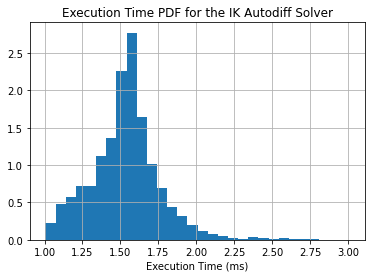

In [14]:
_ = plt.hist(time_stats_ik, bins = 30, density=True)
# plt.axis([0.0,6,0,1.5])
plt.title('Execution Time PDF for the IK Autodiff Solver')
plt.grid(True)
plt.xlabel('Execution Time (ms)')
plt.savefig('IK_autodiff_Solver_Performance.pdf')

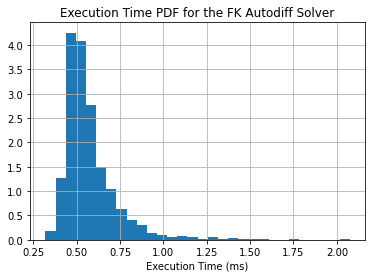

In [15]:
_ = plt.hist(time_stats_fk, bins = 30, density=True)
# plt.axis([0.0,3.5,0,2.0])
plt.title('Execution Time PDF for the FK Autodiff Solver')
plt.grid(True)
plt.xlabel('Execution Time (ms)')
plt.savefig('FK_Autodiff_Solver_Performance.pdf')